In [ ]:
# https://medium.com/@black_swan/how-to-train-word2vec-and-fasttext-embedding-on-wikipedia-corpus-9e8ac45a0c0a
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html


In [1]:
import pandas as pd
import praw
import re
import nltk


import networkx as nx
import gensim.models


import xgboost as xgb
import numba 
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

import sklearn 
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import xgboost as xgb


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
df = pd.read_csv("../Data/wsb_full.csv")
df=df.loc[(((df.removed_by_category.isnull()))) & ((df.is_self==True) & (df.num_comments<=10000) & ~(df["title"].str.contains("Thread|thread|Sunday Live Chat|consolidation zone|Containment Zone|Daily Discussion|Daily discussion|Saturday Chat|What Are Your Moves Tomorrow|What Are Your Moves Today|MEGATHREAD",na=False)))]

In [7]:
df = df.dropna(subset = ['title'])

Preprocessing:


In [ ]:
#average_vector( corpus[0], model)

In [9]:
regex = re.compile('[^a-zA-Z ]')

#@numba.jit # unfortunately this doesn't jit easily :(
def tokenize(text):
    # given a body of text, this splits into sentences, then processes each word in the sentence to remove
    # non alphabetical characters... (? bad idea, what about users with numbers in their name)
    # returns it as a list of lists of words, the format desired by gensims word2vec
    
    sentences = []
    if type(text) == str:
        for sentence in nltk.tokenize.sent_tokenize(text):
            processed = [regex.sub('', word.lower()) for word in sentence.split(' ') ]
            processed = [word for word in processed if word not in set( ['' ])]
            sentences.append(processed)
    return sentences

def average_vector(text, model):
    present_keys = [x for x in text if x in model.wv.key_to_index ]
    if not present_keys:
        return np.zeros(model.wv.vector_size)
    return sum( [model.wv[x] for x in present_keys] ) /len(present_keys)

def average_vector_paragraph(text, model):
    if text == []:
        return np.zeros(model.wv.vector_size)
    return sum( average_vector(sentence, model)  for sentence in text )

## Most similar posts?


def similarity(vec_1, vec_2):
    return sklearn.metrics.pairwise.cosine_similarity([vec_1], [vec_2])[0]

def make_similarity_col(df, given_index):
    given_vector = df['avg_vector'][given_index] 
    df['similarity'] = df['avg_vector'].apply( lambda x : similarity(x, given_vector))
    
# helper function for printing the most similar word vectors

def sims(args, model):
    for word, sim in model.wv.most_similar(**args, topn = 10):
        print( f"{word} - similarity {sim}")
    

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lnajt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
df['tokenized_title'] = df.title.apply(tokenize)
df['tokenized_selftext'] = df.selftext.apply(tokenize)

def train_w2v(tokenized_text):
    # the train dataframe ot build the w2v model on
    
    corpus = []
    for tokenized in tokenized_text:
        corpus += tokenized

    model = gensim.models.Word2Vec(sentences = corpus,  min_count=10, vector_size=300, epochs = 4)
    #model_fasttext = gensim.models.FastText(sentences = corpus,  min_count=10, vector_size=200, epochs = 4)
    
    return model



In [22]:
checker( test_df[2], "dd")
test_df.apply(lambda x : checker(x, "dd"))

False

In [28]:
x = test_df[2]
for sent in x:
    for token in sent:
        print(token)
        print(token == "dd")

2      False
7      False
10     False
15     False
27     False
       ...  
585    False
595    False
600    False
607    False
609    False
Length: 100, dtype: bool

In [33]:
def checker(x, word):
    for sent in x:
        for token in sent:
            if word in token:
                return True
    return False

#test_df = corpus[:100]
corpus.loc [ corpus.apply(lambda x : checker(x, "deepfuckingvalue"))]

268023     [[petition, for, udeepfuckingvalue, to, do, a,...
312461     [[we, should, all, be, thaking, udeepfuckingva...
316437     [[icydk, udeepfuckingvalue, has, videos, detai...
320286     [[udeepfuckingvalue, single, handedly, owns, o...
322485     [[just, some, analysis, on, udeepfuckingvalue,...
                                 ...                        
1201010    [[update, not, originally, posted, on, wsb, cu...
1214105    [[as, i, mentioned, over, two, months, agohttp...
1225975    [[hello, fellow, safter, the, whole, january, ...
1226349    [[in, the, process, of, researching, gme, i, w...
1257977    [[advice, to, new, retards, from, another, rel...
Length: 283, dtype: object

In [12]:
corpus=df['tokenized_title'].append(df['tokenized_selftext'])


In [13]:
model = train_w2v(corpus) 

# in the final pipeline we should only do this on the train set...

# note some Weird stuff in the vocabulary:

# model.wv.key_to_index['p']

#see more with model.wv.key_to_index

In [12]:
#get average vector, put it in the df

#change vectorize to work with both title and text
def vectorize(df, model):
    df['avg_vector'] = (df['tokenized_title']+df['tokenized_selftext']).apply(lambda text : average_vector_paragraph(text, model)) 
    X = np.vstack(df['avg_vector'].to_numpy())
    #df.concat(axis = 1, X)
    return X

vectorize(df,model)

array([[  2.02241206,  -0.0769304 ,  -0.43148822, ...,   2.12895966,
          0.90258253,  -0.98958027],
       [  1.05675566,   2.54573584,  -2.8700707 , ...,   1.21071517,
         -1.81848013,   1.61219263],
       [ -0.96461123,   0.22978646,  -1.67662358, ...,   0.55388248,
         -1.08204508,   0.39968193],
       ...,
       [ -1.46768713,  12.48865128, -15.65144253, ...,   1.08217239,
         -2.12808275,  -2.4791553 ],
       [ -1.27834034,   5.8627286 ,  -9.79122353, ...,   4.22111607,
         -4.22098732,   4.91283798],
       [  1.61823618,   6.01576138,  -6.99719477, ...,   2.06367469,
         -0.99925524,  -3.1643424 ]])

In [56]:
len(df.avg_vector)
#save 
#df.to_csv(path_or_buf="wsb_with_word_vecs.csv",index=False)

59175

In [15]:
model.wv.key_to_index

{'the': 0,
 'to': 1,
 'and': 2,
 'a': 3,
 'of': 4,
 'is': 5,
 'in': 6,
 'i': 7,
 'for': 8,
 'this': 9,
 'that': 10,
 'on': 11,
 'you': 12,
 'it': 13,
 'are': 14,
 'with': 15,
 'be': 16,
 'at': 17,
 'have': 18,
 'they': 19,
 'will': 20,
 'but': 21,
 'as': 22,
 'not': 23,
 'if': 24,
 'we': 25,
 'up': 26,
 'my': 27,
 'all': 28,
 'its': 29,
 'from': 30,
 'so': 31,
 'their': 32,
 'or': 33,
 'has': 34,
 'was': 35,
 'market': 36,
 'just': 37,
 'stock': 38,
 'what': 39,
 'by': 40,
 'can': 41,
 'more': 42,
 'out': 43,
 'your': 44,
 'like': 45,
 'about': 46,
 'now': 47,
 'some': 48,
 'an': 49,
 'buy': 50,
 'im': 51,
 'do': 52,
 'gme': 53,
 'going': 54,
 'get': 55,
 'there': 56,
 'dont': 57,
 'money': 58,
 'price': 59,
 'been': 60,
 'when': 61,
 'time': 62,
 'here': 63,
 'shares': 64,
 'me': 65,
 'people': 66,
 'which': 67,
 'how': 68,
 'one': 69,
 'earnings': 70,
 'down': 71,
 'would': 72,
 'short': 73,
 'go': 74,
 'because': 75,
 'no': 76,
 'know': 77,
 'us': 78,
 'only': 79,
 'into': 80,
 'tha

In [37]:
sims(args = {'positive': ['udeepfuckingvalue'], 'negative' : []} , model = model)

dfv - similarity 0.7326639890670776
gordon - similarity 0.6856907606124878
mr - similarity 0.6574622988700867
lord - similarity 0.6526397466659546
thiel - similarity 0.6456664800643921
lady - similarity 0.636603057384491
chamath - similarity 0.6359416842460632
deepfuckingvalue - similarity 0.6358209848403931
peter - similarity 0.6304816603660583
burry - similarity 0.6292499303817749


In [38]:
sims(args = {'positive': ['wsb'], 'negative' : []} , model = model)

reddit - similarity 0.7776215672492981
sub - similarity 0.692453920841217
wallstreetbets - similarity 0.6687156558036804
rwsb - similarity 0.635865330696106
subreddit - similarity 0.6345683932304382
wsbs - similarity 0.606170117855072
rinvesting - similarity 0.60535728931427
reddits - similarity 0.5673233866691589
memes - similarity 0.5640693306922913
rwallstreetbets - similarity 0.5528467297554016


In [57]:
model.wv.distance('deepfuckingvalue', 'wsb')

0.7288128733634949

In [58]:
model.wv.distance('deepfuckingvalue', 'udeepfuckingvalue')


0.36417895555496216

In [56]:

corpus_df['dist'] = corpus_df[0].apply(lambda x : model.wv.distance('udeepfuckingvalue', x))
corpus_df.sort_values(by = 'dist').head(10)

,0,dist
3396,udeepfuckingvalue,-2.384186e-07
2151,dfv,2.673360e-01
6190,gordon,3.143091e-01
1904,mr,3.425377e-01
2830,lord,3.473604e-01
4077,thiel,3.543332e-01
5241,lady,3.633970e-01
2075,chamath,3.640587e-01
7154,deepfuckingvalue,3.641790e-01
3369,peter,3.695182e-01


In [2]:
df.ups.plot(kind = 'bar')

NameError: name 'df' is not defined

In [70]:
corpus_df = pd.DataFrame(model.wv.key_to_index.keys())

corpus_df['vector'] = corpus_df[0].apply(lambda x : model.wv[x])

In [71]:
corpus_df

,0,vector
0,the,"[-0.15863366, 0.5844454, 0.2222942, 1.1430827,..."
1,to,"[-1.2137154, 0.30949152, -0.025471862, -0.9511..."
2,and,"[0.53669995, 0.30974084, 0.8751791, 0.57580787..."
3,a,"[0.39968562, 1.0213519, -0.6170972, -0.3704636..."
4,of,"[-0.62951034, -0.779958, -0.6353257, -0.678806..."
...,...,...
19245,mistress,"[-0.006583407, 0.041180786, -0.05895677, -0.03..."
19246,whims,"[-0.017779008, 0.016678834, 0.004636627, 0.043..."
19247,truckers,"[0.072631605, 0.06126084, -0.0064754267, 0.011..."
19248,ripples,"[0.053584505, 0.065287836, 0.06669002, 0.10003..."


In [81]:

## Trying clustering:


X = np.vstack(corpus_df['vector'].to_numpy())
model = KMeans(n_clusters= int(len(corpus_df)/200),verbose=1 )
model.fit(X)
corpus_df['prediction'] = model.predict(X)


Initialization complete
Iteration 0, inertia 289268.75
Iteration 1, inertia 248489.078125
Iteration 2, inertia 241542.296875
Iteration 3, inertia 238872.796875
Iteration 4, inertia 237562.109375
Iteration 5, inertia 236793.53125
Iteration 6, inertia 236220.453125
Iteration 7, inertia 235786.40625
Iteration 8, inertia 235462.0
Iteration 9, inertia 235235.5
Iteration 10, inertia 234995.15625
Iteration 11, inertia 234751.8125
Iteration 12, inertia 234583.8125
Iteration 13, inertia 234362.109375
Iteration 14, inertia 234223.296875
Iteration 15, inertia 234128.3125
Iteration 16, inertia 234047.46875
Iteration 17, inertia 233944.96875
Iteration 18, inertia 233857.828125
Iteration 19, inertia 233775.03125
Iteration 20, inertia 233746.109375
Iteration 21, inertia 233716.40625
Iteration 22, inertia 233694.34375
Iteration 23, inertia 233679.625
Iteration 24, inertia 233672.921875
Iteration 25, inertia 233671.109375
Iteration 26, inertia 233669.1875
Iteration 27, inertia 233666.46875
Iteration 28

Iteration 23, inertia 233591.375
Iteration 24, inertia 233555.359375
Iteration 25, inertia 233505.65625
Iteration 26, inertia 233478.421875
Iteration 27, inertia 233452.5625
Iteration 28, inertia 233429.03125
Iteration 29, inertia 233394.5
Iteration 30, inertia 233373.015625
Iteration 31, inertia 233360.5
Iteration 32, inertia 233355.453125
Iteration 33, inertia 233345.078125
Iteration 34, inertia 233335.609375
Iteration 35, inertia 233323.671875
Iteration 36, inertia 233314.75
Iteration 37, inertia 233308.671875
Iteration 38, inertia 233306.5
Iteration 39, inertia 233304.640625
Iteration 40, inertia 233302.609375
Iteration 41, inertia 233301.015625
Iteration 42, inertia 233299.03125
Iteration 43, inertia 233296.875
Iteration 44, inertia 233295.5
Iteration 45, inertia 233294.59375
Iteration 46, inertia 233292.890625
Iteration 47, inertia 233292.28125
Iteration 48, inertia 233291.421875
Iteration 49, inertia 233291.125
Iteration 50, inertia 233291.21875
Iteration 51, inertia 233291.1562

Iteration 16, inertia 234100.3125
Iteration 17, inertia 234040.171875
Iteration 18, inertia 233968.828125
Iteration 19, inertia 233918.390625
Iteration 20, inertia 233902.015625
Iteration 21, inertia 233878.21875
Iteration 22, inertia 233855.796875
Iteration 23, inertia 233826.59375
Iteration 24, inertia 233789.484375
Iteration 25, inertia 233759.203125
Iteration 26, inertia 233684.78125
Iteration 27, inertia 233632.125
Iteration 28, inertia 233605.234375
Iteration 29, inertia 233560.21875
Iteration 30, inertia 233543.484375
Iteration 31, inertia 233511.703125
Iteration 32, inertia 233492.359375
Iteration 33, inertia 233472.96875
Iteration 34, inertia 233453.890625
Iteration 35, inertia 233428.109375
Iteration 36, inertia 233394.46875
Iteration 37, inertia 233342.890625
Iteration 38, inertia 233304.8125
Iteration 39, inertia 233273.65625
Iteration 40, inertia 233226.234375
Iteration 41, inertia 233197.21875
Iteration 42, inertia 233180.203125
Iteration 43, inertia 233172.109375
Iterati

Iteration 34, inertia 234142.625
Iteration 35, inertia 234136.015625
Iteration 36, inertia 234133.046875
Iteration 37, inertia 234131.03125
Iteration 38, inertia 234127.5625
Iteration 39, inertia 234124.921875
Iteration 40, inertia 234119.296875
Iteration 41, inertia 234115.5
Iteration 42, inertia 234114.0625
Iteration 43, inertia 234112.5
Iteration 44, inertia 234110.796875
Iteration 45, inertia 234108.984375
Iteration 46, inertia 234106.65625
Iteration 47, inertia 234106.03125
Iteration 48, inertia 234105.515625
Iteration 49, inertia 234104.71875
Iteration 50, inertia 234102.625
Iteration 51, inertia 234101.6875
Iteration 52, inertia 234099.140625
Iteration 53, inertia 234094.359375
Iteration 54, inertia 234084.515625
Iteration 55, inertia 234077.5625
Iteration 56, inertia 234072.59375
Iteration 57, inertia 234066.0
Iteration 58, inertia 234060.3125
Iteration 59, inertia 234044.375
Iteration 60, inertia 234021.625
Iteration 61, inertia 233992.28125
Iteration 62, inertia 233982.390625

In [82]:
corpus_df.sort_values(by = 'prediction')

,0,vector,prediction
9624,underperform,"[0.04264436, 0.010671392, -0.0026223322, 0.101...",0
13408,establishes,"[0.07293577, 0.12200847, 0.017840182, 0.081843...",0
13409,hibernation,"[0.08164697, 0.0022972072, 0.07608037, 0.05746...",0
13410,xbwith,"[0.035285275, 0.073433176, 0.003781035, 0.0738...",0
13411,chugging,"[0.037948105, 0.078350365, 0.015766835, 0.0375...",0
...,...,...,...
2009,healthy,"[-0.29209498, 0.5816805, 0.33571965, 0.3016169...",95
430,bullish,"[-0.75729316, 0.29634044, -0.0704159, 0.667996...",95
1957,steady,"[-0.18897806, -0.19309734, 0.45669228, 0.54039...",95
224,low,"[1.0592364, 0.6121176, -0.036132313, 1.0800985...",95


In [92]:
list(corpus_df[corpus_df.prediction == 89][0])

['day', 'week', 'year', 'month', 'quarter', 'decade']

In [93]:
list(corpus_df[corpus_df.prediction == 43][0])

['days', 'years', 'months', 'weeks', 'quarters']

In [94]:
list(corpus_df[corpus_df.prediction == 28][0])

['after',
 'last',
 'next',
 'past',
 'ago',
 'recent',
 'later',
 'previous',
 'prior',
 'earlier']

In [95]:
list(corpus_df[corpus_df.prediction == 42][0])

['demand',
 'home',
 'power',
 'energy',
 'supply',
 'space',
 'production',
 'stores',
 'costs',
 'store',
 'consumer',
 'cars',
 'food',
 'spending',
 'delivery',
 'manufacturing',
 'infrastructure',
 'travel',
 'chain',
 'vehicles',
 'airlines',
 'steel',
 'gas',
 'capacity',
 'operations',
 'commercial',
 'sectors',
 'estate',
 'air',
 'physical',
 'storage',
 'fuel',
 'solar',
 'clean',
 'cruise',
 'natural',
 'equipment',
 'consumers',
 'industries',
 'traffic',
 'goods',
 'industrial',
 'mining',
 'evs',
 'locations',
 'hydrogen',
 'shortage',
 'batteries',
 'charging',
 'retailers',
 'restaurants',
 'inventory',
 'materials',
 'homes',
 'shopping',
 'shipping',
 'manufacturers',
 'trucks',
 'domestic',
 'autonomous',
 'construction',
 'ships',
 'nuclear',
 'chains',
 'producers',
 'grocery',
 'stations',
 'renewable',
 'plants',
 'supplies',
 'factories',
 'transportation',
 'brick',
 'electricity',
 'consumption',
 'mortar']

In [98]:
list(corpus_df[corpus_df.prediction == 35][0])

['from',
 'by',
 'due',
 'current',
 'based',
 'target',
 'companys',
 'increased',
 'vs',
 'compared',
 'reported',
 'increasing',
 'growing',
 'record',
 'despite',
 'leading',
 'initial',
 'significantly',
 'annual',
 'continued',
 'increases',
 'bln',
 'targets',
 'raised',
 'relative',
 'gdp',
 'decreased',
 'rose',
 'adjusted',
 'decrease',
 'forecast',
 'driven',
 'boost',
 'revised',
 'reduced',
 'holiday',
 'grew',
 'beating',
 'projected',
 'expects',
 'subscribers',
 'forecasts',
 'decreasing',
 'declined',
 'precovid',
 'respectively',
 'deliveries',
 'generated',
 'projections',
 'improved',
 'versus',
 'improvement',
 'reduction',
 'comparable',
 'steadily',
 'reducing',
 'declining',
 'jobless',
 'yy',
 'yearly',
 'recurring',
 'lowered',
 'cagr',
 'rev',
 'subscriber',
 'bookings',
 'exceeded']

In [102]:
# K means to handle
corpus_df

,0,vector,prediction
0,the,"[-0.15863366, 0.5844454, 0.2222942, 1.1430827,...",3
1,to,"[-1.2137154, 0.30949152, -0.025471862, -0.9511...",4
2,and,"[0.53669995, 0.30974084, 0.8751791, 0.57580787...",4
3,a,"[0.39968562, 1.0213519, -0.6170972, -0.3704636...",82
4,of,"[-0.62951034, -0.779958, -0.6353257, -0.678806...",65
...,...,...,...
19245,mistress,"[-0.006583407, 0.041180786, -0.05895677, -0.03...",0
19246,whims,"[-0.017779008, 0.016678834, 0.004636627, 0.043...",0
19247,truckers,"[0.072631605, 0.06126084, -0.0064754267, 0.011...",0
19248,ripples,"[0.053584505, 0.065287836, 0.06669002, 0.10003...",0


In [106]:
corpus_df = corpus_df.set_index(0)
cluster_dictionary = dict(corpus_df['prediction'])

In [117]:
cluster_dictionary['the']

3

In [99]:
#corpus_df.to_csv("word_clusters_nclusters_lendiv200.csv")

In [122]:
def replace_with_cluster_labels(tokenization, corpus_df):
    clusters = []
    for sent in tokenization:
        for token in sent:
            if token in cluster_dictionary:
                clusters.append( cluster_dictionary[token])
    return clusters

def cluster_counter(tokenization, value):
    counter = 0
    for sent in tokenization:
        for token in sent:
            if token in cluster_dictionary:
                if cluster_dictionary[token] == value:
                    counter += 1
    return counter


#df['title_clusters'] = df['tokenized_title'].apply(lambda x : replace_with_cluster_labels(x, corpus_df))
#df['selftext_clusters'] = df['tokenized_selftext'].apply(lambda x : replace_with_cluster_labels(x, corpus_df))


In [ ]:
#value_list = list( set(cluster_dictionary.values()))
#value_list

In [131]:
for value in value_list:
    print(value)
    df["title_cluster_" + str(value) + "_counts"] = df['tokenized_title'].apply(lambda x : cluster_counter(x, value))
    df["selftext_cluster_" + str(value) + "_counts"] = df['tokenized_selftext'].apply(lambda x : cluster_counter(x, value))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


In [141]:
cols = []

for value in value_list:
    cols.append("title_cluster_" + str(value) + "_counts")
    cols.append("selftext_cluster_" + str(value) + "_counts")
    

192

working on LinearRegression()


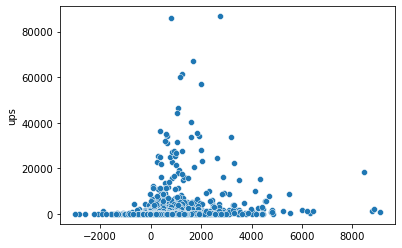

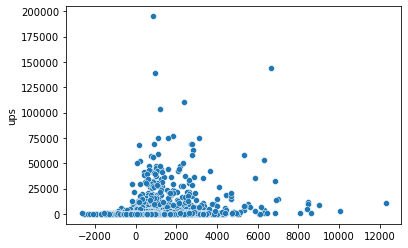

[1. 1. 1. 1. 1.]
working on XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=2, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


KeyboardInterrupt: 

In [ ]:
def run_experiment(model, df):

    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['ups']), df.ups,
                                                    random_state=0)

    print("working on", model)

    pipe = make_pipeline( model)
    pipe.fit(X_train, y_train)

    pipe.predict(X_test)

    sns.scatterplot(x = pipe.predict(X_test), y = y_test)
    plt.show()
    sns.scatterplot(x = pipe.predict(X_train), y = y_train)
    plt.show()
    
    scores = cross_val_score(pipe, df.drop(columns = ['ups']), df.ups)
    print(scores)

for model in [LinearRegression(), xgb.XGBRegressor(random_state=2)]:
    run_experiment(model, df[cols + ['ups']])


In [145]:
df[cols]

,title_cluster_0_counts,selftext_cluster_0_counts,title_cluster_1_counts,selftext_cluster_1_counts,title_cluster_2_counts,selftext_cluster_2_counts,title_cluster_3_counts,selftext_cluster_3_counts,title_cluster_4_counts,selftext_cluster_4_counts,...,title_cluster_91_counts,selftext_cluster_91_counts,title_cluster_92_counts,selftext_cluster_92_counts,title_cluster_93_counts,selftext_cluster_93_counts,title_cluster_94_counts,selftext_cluster_94_counts,title_cluster_95_counts,selftext_cluster_95_counts
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0,2,0,1,0,0,0,2,0,8,...,0,1,0,2,0,0,0,0,0,0
10,0,1,0,0,0,0,1,1,0,2,...,0,0,1,1,0,0,0,0,0,1
15,0,0,0,0,0,0,0,0,1,3,...,0,0,0,0,0,1,0,0,0,0
27,2,4,0,0,0,1,2,10,2,9,...,0,0,0,1,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259949,0,14,0,2,0,13,4,50,0,69,...,0,4,0,0,0,4,0,5,0,13
1260007,0,26,0,8,0,8,0,39,1,69,...,0,0,0,1,0,5,0,4,0,13
1260046,0,16,0,0,0,2,0,40,0,59,...,0,0,0,0,0,0,0,8,0,13
1260101,0,4,0,1,0,3,0,12,0,30,...,0,1,0,0,0,0,0,1,0,1


In [ ]:

clustering = SpectralClustering(n_clusters = 2).fit(X)
df_popular['prediction'] = clustering.labels_

In [159]:
sims(args = {'positive': ['gme'], 'negative' : []} , model = model)

nok - similarity 0.5628875494003296
amc - similarity 0.5547893643379211
gamestop - similarity 0.5469179749488831
gmeamc - similarity 0.5361574292182922
bb - similarity 0.5265468955039978
cashapp - similarity 0.522383987903595
pltr - similarity 0.48038598895072937
shares - similarity 0.46201810240745544
gmc - similarity 0.4483102560043335
tsla - similarity 0.43883076310157776


In [ ]:
# sims(args = {'positive': ['gme'], 'negative' : []} , model = model_fasttext)

In [38]:
sims(args = {'positive': ['tendies'], 'negative' : []} , model = model)

trendies - similarity 0.7260167002677917
bananas - similarity 0.6235389113426208
gains - similarity 0.6222725510597229
tenders - similarity 0.6105455756187439
monies - similarity 0.5806984901428223
profits - similarity 0.5676225423812866
chips - similarity 0.5655564665794373
crayons - similarity 0.5538128018379211
gainz - similarity 0.5533955693244934
ramen - similarity 0.5439910888671875


In [39]:
sims(args = {'positive': ['normies'], 'negative' : []} , model = model)

boomers - similarity 0.7184165120124817
shills - similarity 0.6299222707748413
algos - similarity 0.6103640794754028
redditors - similarity 0.6075345873832703
fags - similarity 0.6004220247268677
millennials - similarity 0.6000107526779175
amateurs - similarity 0.5851551294326782
trolls - similarity 0.5739937424659729
capitalists - similarity 0.5720924735069275
bots - similarity 0.5709673762321472


In [40]:
sims(args = {'positive': ['brain', 'tendies'], 'negative' : ['wrinkles']} , model = model)

gains - similarity 0.5351545810699463
profits - similarity 0.47239649295806885
gainz - similarity 0.4687989056110382
soul - similarity 0.4606021046638489
gf - similarity 0.44966116547584534
money - similarity 0.44946685433387756
bananas - similarity 0.44762393832206726
wife - similarity 0.4469150900840759
heart - similarity 0.4385174512863159
mom - similarity 0.43741828203201294


In [41]:
sims(args = {'positive': ['king', 'woman'], 'negative' : ['man']} , model = model)

overlord - similarity 0.6376240849494934
saint - similarity 0.6238170862197876
prophet - similarity 0.6131112575531006
patron - similarity 0.6117268204689026
messiah - similarity 0.6115373373031616
queen - similarity 0.606661856174469
leader - similarity 0.6021270155906677
emperor - similarity 0.594168484210968
goat - similarity 0.592577338218689
saviour - similarity 0.5735287070274353


In [42]:
sims(args = {'positive': ['lol']} , model = model)

lmao - similarity 0.7220719456672668
haha - similarity 0.5473056435585022
cuz - similarity 0.5311461687088013
wow - similarity 0.4764846861362457
kinda - similarity 0.47304728627204895
yeah - similarity 0.45775654911994934
bc - similarity 0.45566490292549133
tho - similarity 0.4429238736629486
huh - similarity 0.44158363342285156
bro - similarity 0.43773791193962097


In [4]:
## Saving and loading

import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    #model.save(temporary_filepath)
    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.
    #
    # To load a saved model:
    #
    new_model = gensim.models.Word2Vec.load(temporary_filepath)

EOFError: Ran out of input

In [ ]:
#new_model = gensim.models.Word2Vec.load(temporary_filepath)

Some preliminary regression /classification below -- this is slated to get moved

In [64]:
make_similarity_col(df, 0)

In [ ]:
## Question: Finding similar posts:
df_s = df.sort_values(by='similarity', ascending = False)


In [145]:
df_s

,Unnamed: 0,title,author,created_datetime_utc,selftext,url,upvote_ratio,ups,total_awards_received,num_comments,...,is_self,is_video,media_only,id,created_utc,selftext_html,author_fullname,tokenized_title,avg_vector,similarity
0,0,Good time to get on $BLUE,None,2020-01-01 23:53:34,[deleted]\n,https://www.reddit.com/r/wallstreetbets/commen...,0.75,6,0,17,...,True,False,False,eipxnr,1.577923e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN,"[[good, time, to, get, on, blue]]","[-0.068030335, -0.25661317, 0.37836778, -1.168...",[0.99999994]
517223,217951,Good time to get in on bb,mhx19,2021-01-28 14:39:09,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,True,False,False,l6y8v6,1.611845e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_3rrr5uk2,"[[good, time, to, get, in, on, bb]]","[0.1906106, -0.5719585, 0.53236496, -0.9956891...",[0.90678805]
1035357,736085,Good time to get in.,None,2021-02-11 17:39:04,[deleted]\n,https://i.redd.it/4otdge53xvg61.jpg,1.00,1,0,0,...,False,False,False,lhpxwp,1.613065e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN,"[[good, time, to, get, in]]","[0.07077851, -0.6582309, 0.4221986, -1.264117,...",[0.90031284]
1217136,917864,$scr good time to buy on the dip,No_Notice_3818,2021-04-07 14:58:12,NaN,https://i.redd.it/6yiolflrmrr61.jpg,1.00,1,0,0,...,False,False,False,mm3ysa,1.617807e+09,NaN,t2_a1knn5vm,"[[scr, good, time, to, buy, on, the, dip]]","[-0.0084776, -0.13850585, 0.12485974, -0.61490...",[0.8249897]
583977,284705,Still a good time to get in on GME?,RedLeg5253,2021-01-29 22:03:55,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,True,False,False,l85n83,1.611958e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_828u6x2c,"[[still, a, good, time, to, get, in, on, gme]]","[0.30612504, -0.57664096, 0.12011887, -1.04539...",[0.81751347]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085752,786480,Atari SA aka PONGF,RVT1970,2021-02-22 17:57:08,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,True,False,False,lpv129,1.614017e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_jc2yrtm,"[[atari, sa, aka, pongf]]","[-0.13945246, 0.11975554, -0.0068137683, 0.176...",[-0.3741174]
663043,363771,Escaped,A-Trigger,2021-01-29 05:08:17,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,True,False,False,l7jzqg,1.611897e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_8mopou9h,[[escaped]],"[-0.017798865, 0.061401956, -0.016595788, 0.04...",[-0.3844504]
1213890,914618,PONGF,Excellent-Habit2886,2021-04-05 14:59:23,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,True,False,False,mkmnii,1.617635e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_7aq7ly1n,[[pongf]],"[-0.02055906, -0.08854937, 0.041225538, 0.1137...",[-0.39948618]
1249826,950554,$PONGF,GoogetyBlamBamShazam,2021-04-30 16:17:19,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,True,False,False,n1xbbd,1.619799e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_9z4jxqam,[[pongf]],"[-0.02055906, -0.08854937, 0.041225538, 0.1137...",[-0.39948618]


In [16]:
## Trying clustering:

df_popular = df[ df.ups >= 5000]
X = np.vstack(df_popular['avg_vector'].to_numpy())
#model = KMeans(n_clusters=5)
#model.fit(X)
#df_popular['prediction'] = model.predict(X)
clustering = SpectralClustering(n_clusters = 2).fit(X)
df_popular['prediction'] = clustering.labels_

sns.scatterplot(data = df_popular, x = 'prediction', y = 'ups')
df_popular[df_popular.prediction == 1]

NameError: name 'SpectralClustering' is not defined

In [23]:
X = np.vstack(df['avg_vector'].to_numpy())

In [24]:
pca=PCA(n_components = .95)
pca.fit(X)

PCA(n_components=0.95)

In [25]:
vars(pca)

{'n_components': 0.95,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'random_state': None,
 'n_features_in_': 300,
 '_fit_svd_solver': 'full',
 'mean_': array([ 0.6633273 ,  2.02069683, -2.45091142, -0.66218277,  0.95719781,
         2.79290125,  0.99596844, -1.82456799, -1.24048954,  0.04826114,
         1.70602278,  1.22230786,  1.71421745,  3.00168641, -1.18843037,
        -1.06258917, -2.5161586 , -2.4005701 ,  1.61013342, -0.57253353,
        -0.76189848, -1.43957247,  0.43122625,  0.78209676,  1.19828907,
        -0.01785317,  0.98196995, -2.39819054,  0.58313261,  1.07726515,
        -1.58439868, -2.75508405, -0.38617537, -0.36855567,  0.75156761,
         1.76465678, -2.61872761,  1.22046781, -0.29859021, -0.21218906,
         0.25992848,  1.88256442, -0.73047074, -0.35333625, -1.8879041 ,
        -1.04712522, -0.61519186, -0.39270852, -0.29799017, -0.48811338,
        -0.97849289,  0.09263238, -0.73634046,  3.08244269,  0.1538

In [26]:
pca2=PCA(n_components = .80)
pca2.fit(X)
vars(pca2)

{'n_components': 0.8,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'random_state': None,
 'n_features_in_': 300,
 '_fit_svd_solver': 'full',
 'mean_': array([ 0.6633273 ,  2.02069683, -2.45091142, -0.66218277,  0.95719781,
         2.79290125,  0.99596844, -1.82456799, -1.24048954,  0.04826114,
         1.70602278,  1.22230786,  1.71421745,  3.00168641, -1.18843037,
        -1.06258917, -2.5161586 , -2.4005701 ,  1.61013342, -0.57253353,
        -0.76189848, -1.43957247,  0.43122625,  0.78209676,  1.19828907,
        -0.01785317,  0.98196995, -2.39819054,  0.58313261,  1.07726515,
        -1.58439868, -2.75508405, -0.38617537, -0.36855567,  0.75156761,
         1.76465678, -2.61872761,  1.22046781, -0.29859021, -0.21218906,
         0.25992848,  1.88256442, -0.73047074, -0.35333625, -1.8879041 ,
        -1.04712522, -0.61519186, -0.39270852, -0.29799017, -0.48811338,
        -0.97849289,  0.09263238, -0.73634046,  3.08244269,  0.15382

In [27]:
pca3=PCA(n_components = 2)
pca3.fit(X)
vars(pca3)

{'n_components': 2,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'random_state': None,
 'n_features_in_': 300,
 '_fit_svd_solver': 'randomized',
 'mean_': array([ 0.6633273 ,  2.02069683, -2.45091142, -0.66218277,  0.95719781,
         2.79290125,  0.99596844, -1.82456799, -1.24048954,  0.04826114,
         1.70602278,  1.22230786,  1.71421745,  3.00168641, -1.18843037,
        -1.06258917, -2.5161586 , -2.4005701 ,  1.61013342, -0.57253353,
        -0.76189848, -1.43957247,  0.43122625,  0.78209676,  1.19828907,
        -0.01785317,  0.98196995, -2.39819054,  0.58313261,  1.07726515,
        -1.58439868, -2.75508405, -0.38617537, -0.36855567,  0.75156761,
         1.76465678, -2.61872761,  1.22046781, -0.29859021, -0.21218906,
         0.25992848,  1.88256442, -0.73047074, -0.35333625, -1.8879041 ,
        -1.04712522, -0.61519186, -0.39270852, -0.29799017, -0.48811338,
        -0.97849289,  0.09263238, -0.73634046,  3.08244269,  0.1

In [28]:
XT=pca3.transform(X)
XT

array([[-20.34215515,   0.73986566],
       [  2.35929712, -11.61835893],
       [-15.58433901,   1.21586316],
       ...,
       [104.39459159,  -4.96666958],
       [ 45.42131047, -41.6735821 ],
       [ 46.24764824,  15.6126067 ]])

In [29]:
len(XT[:,0])

59175

In [54]:
sum([0.64265614, 0.13735534])

0.78001148

<IPython.core.display.Javascript object>


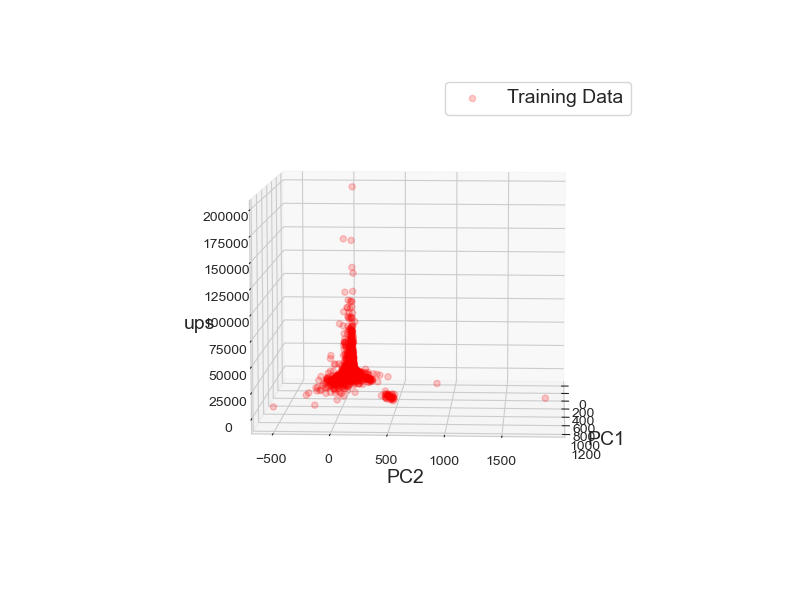

In [31]:
# import the packages we'll use
## For data handling
import pandas as pd
import numpy as np

# We'll use this later
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# This is new, it will allow us to interact with
# 3d plots in the notebook
from mpl_toolkits.mplot3d import Axes3D


## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
%matplotlib notebook
## Now we plot the regression plane
## along with the training observations

## get the prediction this is where meshgrid comes in handy
x1s = np.linspace(XT[:,0].min(), XT[:,0].max(), 10)
x2s = np.linspace(XT[:,1].min(), XT[:,1].max(), 10)

## this makes a meshgrid
x1v, x2v = np.meshgrid(x1s, x2s)
#print(x1v.reshape(-1,1))

## combine x1v and x2v into a single array for prediction
X_grid = np.concatenate([x1v.reshape(-1,1), x2v.reshape(-1,1)], axis=1)

## Make a figure object
fig = plt.figure(figsize=(8,6))

## We'll add a 3d subplot object
ax = fig.add_subplot(111, projection='3d')

## plot_trisurf makes a surface out of triangles
## it will take in the TV grid on the x-axis
## the radio grid on the y-axis
## and the prediction grid on the z-axis
## alpha <1 allows us to see through the surface
#ax.plot_trisurf(X_grid[:, 0], X_grid[:, 1], df_popular['ups'], alpha=0.4)

## scatter will plot the observations from the training set
ax.scatter(XT[:,0], XT[:,1], np.array(df['ups']), c="r", alpha=0.2, label="Training Data")

## Add labels
ax.set_xlabel("PC1", fontsize=14)
ax.set_ylabel("PC2", fontsize=14)
ax.set_zlabel("ups", fontsize=14)

plt.legend(fontsize=14)

plt.show()

In [32]:
sum([0.64265614, 0.13735534])

0.78001148

In [33]:
plt.close()

<IPython.core.display.Javascript object>


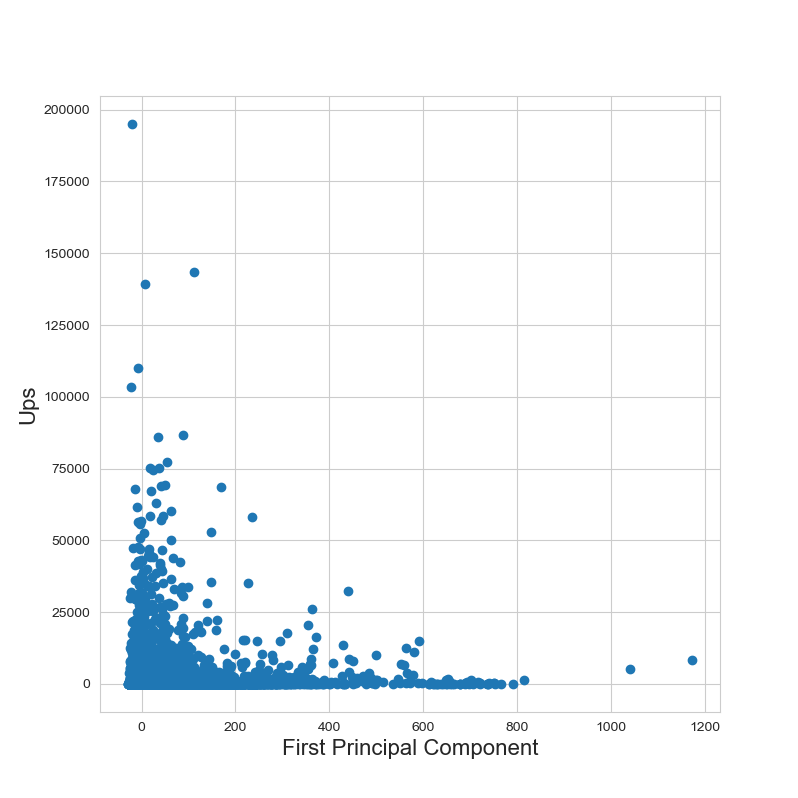

In [34]:
#PC1 vs ups?
#set up figure size
plt.figure(figsize = (8,8))

#df_medium=df_popular.loc[df_popular.ups<=100000]

#make scatter plot. First input is ind variable, second is dep variable
#note these inputs are list-like objects. Really they are pandas Series. But it works for any array-like stuff
plt.scatter(XT[:,0], df['ups'])

## place an xlabel
plt.xlabel("First Principal Component", fontsize =16)

## place a ylabel
plt.ylabel("Ups", fontsize = 16)

## type this to show the plot
plt.show()

<IPython.core.display.Javascript object>


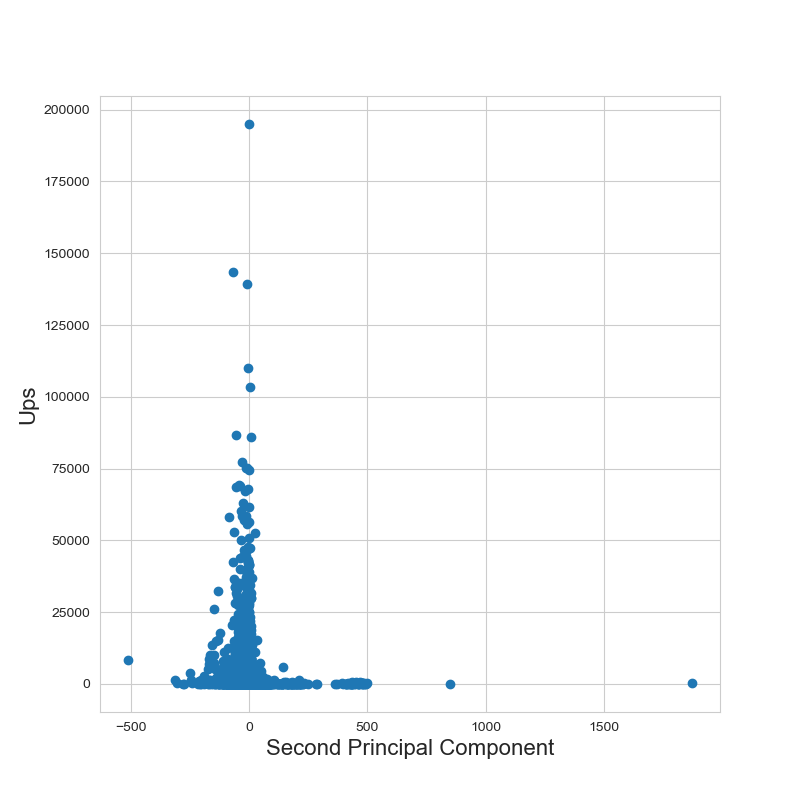

In [36]:
plt.close()

#PC2 vs ups?
#set up figure size
plt.figure(figsize = (8,8))

#make scatter plot. First input is ind variable, second is dep variable
#note these inputs are list-like objects. Really they are pandas Series. But it works for any array-like stuff
plt.scatter(XT[:,1], df['ups'])

## place an xlabel
plt.xlabel("Second Principal Component", fontsize =16)

## place a ylabel
plt.ylabel("Ups", fontsize = 16)

## type this to show the plot
plt.show()

In [37]:
plt.close()

In [14]:
#set up logistic regression
#first, throw out the comment outliers
#df_no_outliers=df.loc[(df.is_self==True) & (df.num_comments<=10000) & ~(df["title"].str.contains("Thread|thread|Sunday Live Chat|consolidation zone|Containment Zone|Daily Discussion|Daily discussion|Saturday Chat|What Are Your Moves Tomorrow|What Are Your Moves Today|MEGATHREAD",na=False))]
#set up usable vec data
X = np.vstack(df['avg_vector'].to_numpy())
#next, add popularity column
def PopClassifyn(ups,n):
    if ups <n:
        return 0
    else:
        return 1
df['popularity'] = df['ups'].map(lambda score: PopClassifyn(score,2))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, df['popularity'], test_size=0.2, random_state=46,stratify=df['popularity'])

In [18]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=10000)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

p=lr.predict(X_train)
#print(np.mean(p==y_train))
print("accuracy on training data:")
print(accuracy_score(y_train,p))
print(np.mean(y_train==0))
print("accuracy on testing data:")
print(np.mean(lr.predict(X_test)==y_test))
print(np.mean(y_test==0))

accuracy on training data:
0.8991761723700887
0.11934938741022391
accuracy on testing data:
0.9000422475707647
0.11939163498098859


In [67]:
from sklearn.model_selection import cross_validate as cv
from sklearn.metrics import SCORERS as sc
from sklearn.metrics import make_scorer as ms
from sklearn.metrics import balanced_accuracy_score as bas
scorer_dict={
    'accuracy_scorer' : ms(accuracy_score),
    'auc_scorer' : ms(roc_auc_score),
    'bas_scorer' : ms(bas)
}

In [69]:
scores=cv(LogisticRegression(max_iter=1000),X,df['popularity'],cv=5,scoring=scorer_dict, return_train_score=True)

C:\Users\jason\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


KeyboardInterrupt: 

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, df['ups'], test_size = 0.2, random_state = 10)

935262     222
416369       1
382858      18
884008       1
761128       1
          ... 
1114747      4
408280       2
888239       1
1010336      1
508714       3
Name: ups, Length: 252048, dtype: int64

In [39]:
from sklearn.metrics import mean_squared_error

# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

5964180.188871892

In [52]:
from sklearn.metrics import r2_score
print(r2_score(y_train,xgr.predict(X_train)))
print(r2_score(y_test,xgr.predict(X_test)))

0.9212003305822605
-0.15012814244723294


<IPython.core.display.Javascript object>


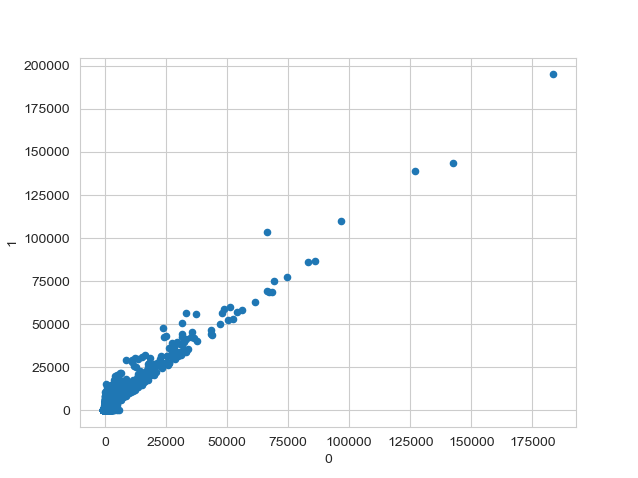

<AxesSubplot:xlabel='0', ylabel='1'>

In [41]:
plot = pd.DataFrame([xgr.predict(X_train), y_train])
plot.transpose().plot(kind = 'scatter', x = 0, y = 1)

<IPython.core.display.Javascript object>


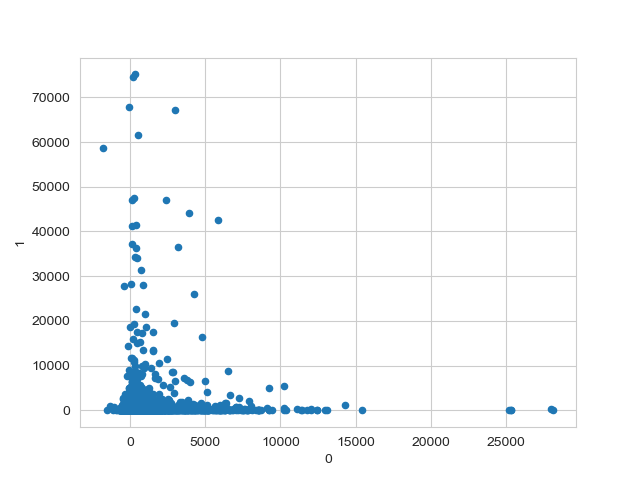

<AxesSubplot:xlabel='0', ylabel='1'>

In [53]:
plt.close()
plot = pd.DataFrame([xgr.predict(X_test), y_test])
plot.transpose().plot(kind = 'scatter', x = 0, y = 1)

In [43]:
plt.close()
plot = pd.DataFrame([y_pred, y_test])

<IPython.core.display.Javascript object>


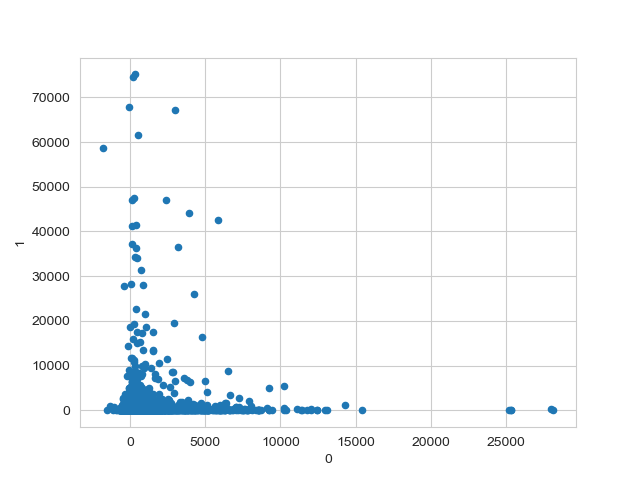

<AxesSubplot:xlabel='0', ylabel='1'>

In [44]:
plot.transpose().plot(kind = 'scatter', x = 0, y = 1)

In [45]:
plt.close()
output = pd.DataFrame(y_test)
output['pred'] = y_pred

In [46]:
df_with_pred = df.merge(output, right_index = True, left_index = True)

In [47]:
df_with_pred.sort_values(by = 'pred', ascending = False)

,id,comment_limit,comment_sort,_reddit,approved_at_utc,subreddit,selftext,user_reports,saved,mod_reason_title,...,event_is_live,is_gallery,gallery_data,collections,tokenized_title,tokenized_selftext,avg_vector,popularity,ups_y,pred
255337,jz73qu,2048,confidence,<praw.reddit.Reddit object at 0x000001EEABC88040>,NaN,wallstreetbets,Hey guys im last weeks retarded who used a Rou...,[],False,NaN,...,NaN,NaN,NaN,NaN,"[[roulettecoinflip, strat, nov, plays]]","[[hey, guys, im, last, weeks, retarded, who, u...","[15.168888, 1.9184979, -2.101612, -12.056615, ...",0,0,28126.166016
414517,l7cry8,2048,confidence,<praw.reddit.Reddit object at 0x000001EF903BDBE0>,NaN,wallstreetbets,"After this debacle of a fuck stick, I want to ...",[],False,NaN,...,NaN,NaN,NaN,NaN,"[[moving, my, positions, out, of, robinhood, y...","[[after, this, debacle, of, a, fuck, stick, i,...","[-0.14032024, 2.7705789, -10.932139, -4.371654...",1,220,27969.457031
297365,kmoayh,2048,confidence,<praw.reddit.Reddit object at 0x000001EEABC88040>,NaN,wallstreetbets,OK listen up. Here is a story for everyone. I ...,[],False,NaN,...,NaN,NaN,NaN,NaN,"[[story, from, a, retard, pltr, hole, the, line]]","[[ok, listen, up], [here, is, a, story, for, e...","[2.1346085, 11.314061, -11.524504, -9.953445, ...",1,68,25276.285156
899447,lazb15,2048,confidence,<praw.reddit.Reddit object at 0x000001EF903BDBE0>,NaN,wallstreetbets,"Not a single one of us can do this alone, and ...",[],False,NaN,...,NaN,NaN,NaN,NaN,"[[buy, when, theres, blood, in, the, street, e...","[[not, a, single, one, of, us, can, do, this, ...","[2.172661781311035, 6.9946417808532715, -6.796...",1,125,25274.064453
993374,lcfm96,2048,confidence,<praw.reddit.Reddit object at 0x000001EF903BDBE0>,NaN,wallstreetbets,"**\*This post is about physical silver, not th...",[],False,NaN,...,NaN,NaN,NaN,NaN,"[[silver, shiny, me, likey, read, disclaimer, ...","[[this, post, is, about, physical, silver, not...","[-0.23411933600436896, 15.586387127754278, -27...",1,59,25188.494141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108003,g69ccz,2048,confidence,<praw.reddit.Reddit object at 0x000001EEABC88040>,NaN,wallstreetbets,"Hello, friends -\n\nIt's me, Fuzzy. [Sorry 4 ...",[],False,NaN,...,NaN,NaN,NaN,NaN,"[[lyv, free, or, die], [fuzzys, live, nation, ...","[[hello, friends, its, me, fuzzy], [sorry, the...","[7.698386532720178, 28.634754868689924, -30.55...",1,663,-1058.842651
160902,hk8jm2,2048,confidence,<praw.reddit.Reddit object at 0x000001EEABC88040>,NaN,wallstreetbets,This is my first DD. I feel really good about ...,[],False,NaN,...,NaN,NaN,NaN,NaN,"[[dd, all, aboard, axdx]]","[[this, is, my, first, dd], [i, feel, really, ...","[4.998998578172177, 35.19280382525176, -30.497...",1,129,-1142.646973
311128,kvm2wh,2048,confidence,<praw.reddit.Reddit object at 0x000001EF903BDBE0>,NaN,wallstreetbets,I've made fun of so many of you GME autists. I...,[],False,NaN,...,NaN,NaN,NaN,NaN,"[[gme, bear, no, more], [going, all, in, tomor...","[[ive, made, fun, of, so, many, of, you, gme, ...","[-1.6421937, 4.941828, -9.095296, -7.3823137, ...",1,874,-1334.770508
391866,l69vl7,2048,confidence,<praw.reddit.Reddit object at 0x000001EF903BDBE0>,NaN,wallstreetbets,GME! GME! GME!,[],False,NaN,...,NaN,NaN,NaN,NaN,"[[we, want]]","[[gme], [gme], [gme]]","[0.17462608, -0.6233638, -3.089271, -5.3965406...",1,10,-1499.001953


In [48]:
df['pred'] = xgr.predict( np.vstack(df['avg_vector'].to_numpy()))

<IPython.core.display.Javascript object>


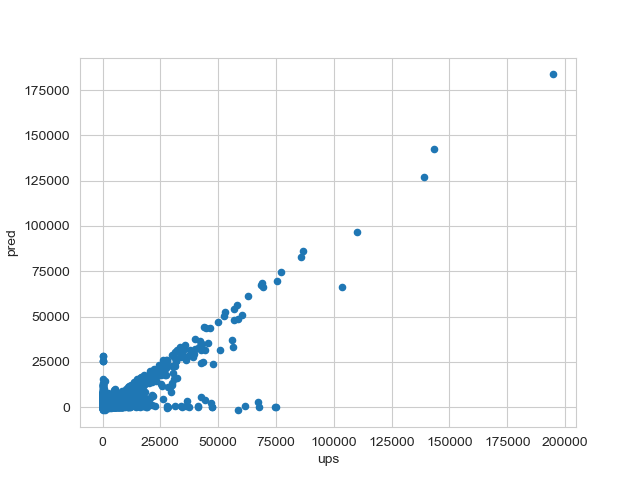

<AxesSubplot:xlabel='ups', ylabel='pred'>

In [49]:
df.plot(kind = 'scatter', x = 'ups', y = 'pred')